In [1]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
import wooldridge
from scipy.stats import gaussian_kde, multivariate_normal, norm, uniform
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [2]:
mroz = wooldridge.data('mroz').dropna(subset=['lwage'])  # 列'lwage'にNaNがある行は削除する

wooldridge.data('mroz',description=True)

name of dataset: mroz
no of variables: 22
no of observations: 753

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| inlf     | =1 if in lab frce, 1975         |
| hours    | hours worked, 1975              |
| kidslt6  | # kids < 6 years                |
| kidsge6  | # kids 6-18                     |
| age      | woman's age in yrs              |
| educ     | years of schooling              |
| wage     | est. wage from earn, hrs        |
| repwage  | rep. wage at interview in 1976  |
| hushrs   | hours worked by husband, 1975   |
| husage   | husband's age                   |
| huseduc  | husband's years of schooling    |
| huswage  | husband's hourly wage, 1975     |
| faminc   | family income, 1975             |
| mtr      | fed. marg. tax rte facing woman |
| motheduc | mother's years of schooling     |
| fatheduc | father's years of schooling     |
| unem     | unem. rate in county of res

In [3]:
form_1 = 'lwage ~ 1 + [educ ~ fatheduc]'

In [4]:
mod_1 = IV2SLS.from_formula(form_1, data=mroz)

In [5]:
res_1 = mod_1.fit(cov_type='unadjusted')

In [6]:
print(res_1.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4411     0.4451     0.9911     0.3216     -0.4312      1.3134
educ           0.0592     0.0351     1.6878     0.0914     -0.0095      0.1279


In [7]:
stage_1 = 'educ ~ 1 + fatheduc'  # 回帰式

res_stage_1 =IV2SLS.from_formula(stage_1, data=mroz).fit(cov_type='unadjusted')  # OLS推定

educ_fit = res_stage_1.fitted_values  # educの予測値を取得

In [8]:
stage_2 = 'lwage ~ 1 + educ_fit'

res_stage_2 =IV2SLS.from_formula(stage_2, data=mroz).fit(cov_type='unadjusted')  # OLS推定

print(res_stage_2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4411     0.4660     0.9465     0.3439     -0.4723      1.3545
educ_fit       0.0592     0.0367     1.6119     0.1070     -0.0128      0.1311


In [9]:
form_ols = 'lwage ~ 1 + educ'

res_ols =IV2SLS.from_formula(form_ols, data=mroz).fit()  # OLS推定

print(res_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.1852     0.1703    -1.0872     0.2770     -0.5191      0.1487
educ           0.1086     0.0134     8.1178     0.0000      0.0824      0.1349


In [10]:
form_check = 'educ ~ 1 + fatheduc + motheduc'

res_check =IV2SLS.from_formula(form_check, data=mroz).fit(cov_type='unadjusted')

print(res_check.summary)

                            OLS Estimation Summary                            
Dep. Variable:                   educ   R-squared:                      0.2081
Estimator:                        OLS   Adj. R-squared:                 0.2043
No. Observations:                 428   F-statistic:                    112.45
Date:                Thu, Jul 23 2020   P-value (F-stat)                0.0000
Time:                        20:43:37   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      9.4801     0.3200     29.627     0.0000      8.8530      10.107
fatheduc       0.1881     0.0335     5.6122     0.00

In [11]:
form_2 = 'lwage ~ 1 + exper + expersq +[educ ~ fatheduc + motheduc]'

In [12]:
res_2 =IV2SLS.from_formula(form_2, data=mroz).fit(cov_type='unadjusted')

print(res_2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0481     0.3985     0.1207     0.9039     -0.7329      0.8291
exper          0.0442     0.0134     3.3038     0.0010      0.0180      0.0704
expersq       -0.0009     0.0004    -2.2485     0.0245     -0.0017     -0.0001
educ           0.0614     0.0313     1.9622     0.0497   7.043e-05      0.1227


In [13]:
N = 10_000

In [14]:
b0 = 0.5
b1 = 1
b2 = 0.5

In [15]:
def sim_iv(n,m,ols=False):  # n=標本の大きさ, m=x1とｚの共分散
    """
    n: 標本の大きさ
    m: 説明変数と対応する操作変数の相関性の度合い
    ols: Boolean（デフォルト：False） 
        False: OLS推定とIV推定も一緒におこなう
            返り値：２つのリスト（OLSとIV推定量）
        True: IV推定のみ
            返り値：１つのリストのみ
    """
    rv_mean = [0, 0, 0]  # x1, x2, z1の平均
    rv_cov = [[1.0, 0.3, m],  # x1, x2, z1の共分散行列
              [0.3, 1.0, 0.0],  # 全ての変数の分散は１（対角成分）
              [m,   0.0, 1.0]]  # Cov(x1,x2)=0.3,  Cov(x2,z)=0, Cov(x1,z)=m,
    rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2, z1をnセット抽出
    x1 = rv[:,0]  # 説明変数
    x2 = rv[:,1]  # 欠落変数
    z = rv[:,2]  # 操作変数

    b1_iv_list = []  # IV推定量を入れる空のリスト
    b1_ols_list = []  # OLS推定量を入れる空のリスト
    
    c = np.ones(n)
    
    for j in range(N):  # N回のループ
        
        u = norm.rvs(size=n)  # 母集団の誤差項
        y = b0 + b1*x1 + b2*x2 + u  # 母集団回帰式
        
        # IV 第１ステージ
        Xiv1 = np.stack([c,z],axis=1)
        pihat = np.linalg.inv((Xiv1.T)@Xiv1)@(Xiv1.T)@x1  # IV推定
        x1hat = Xiv1@pihat  # x1の予測値
        # IV 第２ステージ
        Xiv2 = np.stack([c,x1hat],axis=1)        
        beta_iv = np.linalg.inv((Xiv2.T)@Xiv2)@(Xiv2.T)@y  # IV推定
        b1_iv_list.append(beta_iv[1])  # IV推定量をリストに追加

        if ols==True:  # オプションols=Trueの場合はOLS推定もおこなう
            
            X = np.stack([c,x1],axis=1)
            beta_ols = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
            b1_ols_list.append(beta_ols[1])  # OLS推定量をリストに追加

        else:  # ols=Falseの場合はOLS推定をおこなわない
            pass

    if ols==True:  # ols=True の場合の返り値の設定
        return b1_iv_list, b1_ols_list
    
    else:  # ols=False の場合の返り値の設定
        return b1_iv_list

In [16]:
b1hat_iv, b1hat_ols = sim_iv(1000,0.9,ols=True)

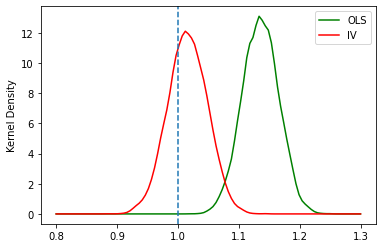

In [17]:
xx=np.linspace(0.8,1.3,num=100)  # 図を作成するために横軸の値を設定

kde_model_ols=gaussian_kde(b1hat_ols)  # OLS推定量のカーネル密度関数を計算

kde_model_iv=gaussian_kde(b1hat_iv)  # IV推定量のカーネル密度関数を計算

plt.plot(xx, kde_model_ols(xx), 'g-', label='OLS')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_iv(xx),'r-', label='IV')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [18]:
b1hat_iv_30 = sim_iv(30,0.8)
b1hat_iv_100 = sim_iv(100,0.8)
b1hat_iv_1000 = sim_iv(1000,0.8)

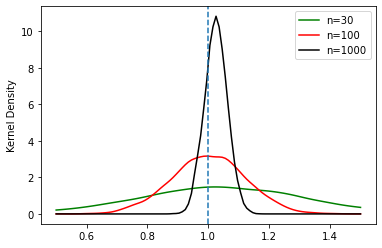

In [19]:
xx=np.linspace(0.5,1.5,num=100)  # 図を作成するために横軸の値を設定

b1hat_iv_n_list = [b1hat_iv_30, b1hat_iv_100, b1hat_iv_1000]
color_list = ['g-', 'r-', 'k-']
label_list = ['n=30', 'n=100', 'n=1000']

for (i, j, k) in zip(b1hat_iv_n_list, color_list, label_list):
    kde_model_iv=gaussian_kde(i)  # IV推定量のカーネル密度推定を設定
    b1_dist = kde_model_iv(xx)  # IV推定量のカーネル密度関数を計算
    plt.plot(xx, b1_dist, j, label=k)  # IV推定量の分布プロット

plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [20]:
b1hat_iv_weak = sim_iv(2000,0.1)
b1hat_iv_mid = sim_iv(2000,0.4)
b1hat_iv_strong = sim_iv(2000,0.8)

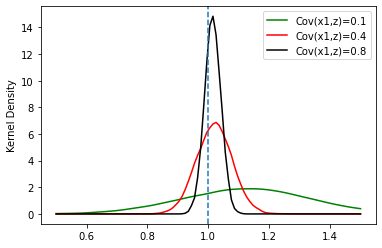

In [21]:
xx=np.linspace(0.5,1.5,num=100)  # 図を作成するために横軸の値を設定

b1hat_iv_n_list = [b1hat_iv_weak, b1hat_iv_mid, b1hat_iv_strong]
color_list = ['g-', 'r-', 'k-']
label_list = ['Cov(x1,z)=0.1', 'Cov(x1,z)=0.4', 'Cov(x1,z)=0.8']

for (i, j, k) in zip(b1hat_iv_n_list, color_list, label_list):
    kde_model_iv=gaussian_kde(i)  # OLS推定量のカーネル密度推定を設定
    b1_dist = kde_model_iv(xx)  # OLS推定量のカーネル密度関数を計算
    plt.plot(xx, b1_dist, j, label=k)  # OLS推定量の分布プロット

plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [22]:
res_2.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 2.8035
P-value: 0.0948
Distributed: F(1,423)
WaldTestStatistic, id: 0x7f9b1c2f9970

In [23]:
form_2a = 'educ ~ 1 + exper + expersq + motheduc + fatheduc'

mod_2a = IV2SLS.from_formula(form_2a, data=mroz)

res_2a = mod_2a.fit(cov_type='unadjusted')

In [24]:
form_2b = 'lwage ~ 1 + educ + exper + expersq + res_2a.resids'

mod_2b = IV2SLS.from_formula(form_2b, data=mroz)

res_2b = mod_2b.fit(cov_type='unadjusted')

print(res_2b.summary.tables[1])

                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.0481     0.3923     0.1226     0.9024     -0.7207      0.8169
educ              0.0614     0.0308     1.9932     0.0462      0.0010      0.1218
exper             0.0442     0.0132     3.3559     0.0008      0.0184      0.0700
expersq          -0.0009     0.0004    -2.2840     0.0224     -0.0017     -0.0001
res_2a.resids     0.0582     0.0346     1.6810     0.0928     -0.0097      0.1260


In [25]:
res_2.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 2.8256
P-value: 0.0928
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f9b1d991580

In [26]:
form_aux = 'res_2.resids ~ 1 + motheduc + fatheduc + exper + expersq' # 外生的説明変数を省いてもよい

mod_aux = IV2SLS.from_formula(form_aux, data=mroz)

res_aux = mod_aux.fit(cov_type='unadjusted')

In [27]:
r2 = res_aux.rsquared  # 決定係数
n = res_aux.nobs    # 標本の大きさ
teststat = n * r2      # 検定統計量
pval = 1 - chi2.cdf(teststat, 1)  # p値の計算
print(pval)

0.5386372330714875


In [28]:
res_2.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 0.3781
P-value: 0.5386
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f9b1c998ac0

In [29]:
form_L = 'hours ~ 1 + educ + age + kidslt6 + nwifeinc + [lwage ~ exper + expersq]'

mod_L = IV2SLS.from_formula(form_L, data=mroz)

res_L = mod_L.fit(cov_type='unadjusted')

print(res_L.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2225.7     570.52     3.9011     0.0001      1107.5      3343.9
educ          -183.75     58.684    -3.1312     0.0017     -298.77     -68.733
age           -7.8061     9.3120    -0.8383     0.4019     -26.057      10.445
kidslt6       -198.15     181.64    -1.0909     0.2753     -554.17      157.86
nwifeinc      -10.170     6.5682    -1.5483     0.1215     -23.043      2.7039
lwage          1639.6     467.27     3.5088     0.0005      723.73      2555.4


In [30]:
form_L_ols = 'hours ~ 1 + educ + age + kidslt6 + nwifeinc + lwage '

mod_L_ols = IV2SLS.from_formula(form_L_ols, data=mroz)

res_L_ols = mod_L_ols.fit(cov_type='unadjusted')

print(res_L_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1523.8     303.43     5.0219     0.0000      929.07      2118.5
educ          -6.6219     17.989    -0.3681     0.7128     -41.879      28.636
age            0.5623     5.1039     0.1102     0.9123     -9.4411      10.566
kidslt6       -328.86     100.74    -3.2643     0.0011     -526.31     -131.40
nwifeinc      -5.9185     3.6574    -1.6182     0.1056     -13.087      1.2500
lwage         -2.0468     54.494    -0.0376     0.9700     -108.85      104.76


In [31]:
form_P = 'lwage ~ 1 + educ + exper + expersq + [hours ~ age + kidslt6 + nwifeinc]'

mod_P = IV2SLS.from_formula(form_P, data=mroz)

res_P = mod_P.fit(cov_type='unadjusted')

print(res_P.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.6557     0.3358    -1.9527     0.0509     -1.3139      0.0024
educ           0.1103     0.0154     7.1488     0.0000      0.0801      0.1406
exper          0.0346     0.0194     1.7847     0.0743     -0.0034      0.0726
expersq       -0.0007     0.0005    -1.5634     0.1179     -0.0016      0.0002
hours          0.0001     0.0003     0.4974     0.6189     -0.0004      0.0006


In [32]:
form_W_ols = 'lwage ~ 1 + educ + exper + expersq + hours'

mod_W_ols = IV2SLS.from_formula(form_W_ols, data=mroz)

res_W_ols = mod_W_ols.fit(cov_type='unadjusted')

print(res_W_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4620     0.2027    -2.2797     0.0226     -0.8592     -0.0648
educ           0.1062     0.0141     7.5400     0.0000      0.0786      0.1338
exper          0.0447     0.0133     3.3590     0.0008      0.0186      0.0708
expersq       -0.0009     0.0004    -2.1883     0.0286     -0.0016   -8.96e-05
hours      -5.655e-05  4.353e-05    -1.2992     0.1939     -0.0001   2.876e-05


In [33]:
n = 1000
N = 10_000

In [34]:
b0 = 1.0
b1 = 1.0

In [35]:
x_pop = uniform.rvs(1,10,size=n)  # 母集団の説明変数
u = norm.rvs(scale=1, size=n)  # 母集団の誤差項
y = b0 + b1*x_pop + u  # 母集団回帰式

In [36]:
error_sd = 3

In [37]:
# シミュレーションで計算した推定量を入れる空のリストの作成
b1_ols_list = []  # OLS推定量
b1_iv_list = []  # IV推定量

for j in range(N):  # N回のループ
    x = x_pop + norm.rvs(scale=error_sd, size=n)  # 測定誤差
    z = x_pop + norm.rvs(scale=error_sd, size=n)  # 操作変数
    
    c = np.ones(n)  # 定数項
    
    # IV 第１ステージ
    Xiv1 = np.stack([c,z],axis=1)
    pihat = np.linalg.inv((Xiv1.T)@Xiv1)@(Xiv1.T)@x  # IV推定
    xhat = Xiv1@pihat  # x1の予測値
    # IV 第２ステージ
    Xiv2 = np.stack([c,xhat],axis=1)        
    beta_iv = np.linalg.inv((Xiv2.T)@Xiv2)@(Xiv2.T)@y  # IV推定
    b1_iv_list.append(beta_iv[1])  # b1のIV推定量をリストに追加

    # OLS
    X = np.stack([c,x],axis=1)        
    beta_ols = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
    b1_ols_list.append(beta_ols[1])  # b1のOLS推定量

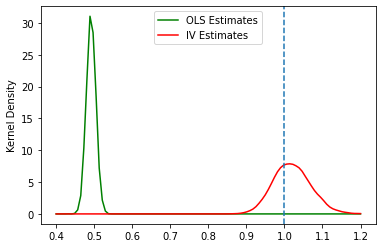

In [38]:
xx=np.linspace(0.4,1.2,num=100)  # 図を作成するために横軸の値を設定

kde_model_ols=gaussian_kde(b1_ols_list)  # t値のカーネル密度推定を設定
b1_ols_dist = kde_model_ols(xx)

kde_model_iv=gaussian_kde(b1_iv_list)  # t値のカーネル密度推定を設定
b1_iv_dist = kde_model_iv(xx)

plt.plot(xx, b1_ols_dist, 'g-', label='OLS Estimates')  # t値の分布プロット
plt.plot(xx, b1_iv_dist,'r-', label='IV Estimates')  # t分布
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()
pass